In [ ]:
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.color as color
import random as r
import math
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, LeakyReLU
from keras.layers import Input, UpSampling2D,BatchNormalization, ZeroPadding2D, Reshape, Permute
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import os
import argparse
import sys
import cv2
import skimage.transform as trans

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/final_grape_data.zip

Archive:  /content/drive/MyDrive/final_grape_data.zip
   creating: final_grape_data/image/
  inflating: final_grape_data/image/1 (1).png  
  inflating: final_grape_data/image/1 (10).png  
  inflating: final_grape_data/image/1 (100).png  
  inflating: final_grape_data/image/1 (101).png  
  inflating: final_grape_data/image/1 (102).png  
  inflating: final_grape_data/image/1 (103).png  
  inflating: final_grape_data/image/1 (104).png  
  inflating: final_grape_data/image/1 (105).png  
  inflating: final_grape_data/image/1 (106).png  
  inflating: final_grape_data/image/1 (107).png  
  inflating: final_grape_data/image/1 (108).png  
  inflating: final_grape_data/image/1 (109).png  
  inflating: final_grape_data/image/1 (11).png  
  inflating: final_grape_data/image/1 (110).png  
  inflating: final_grape_data/image/1 (111).png  
  inflating: final_grape_data/image/1 (112).png  
  inflating: final_grape_data/image/1 (113).png  
  inflating: final_grape_data/image/1 (114).png  
  inflating: 

In [ ]:
def read_and_preprocess_images(folder_path, target_size=(128, 128), grayscale=False):
    images = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            if grayscale:
                image = cv2.imread(image_path, 0)
                image = np.expand_dims(image, axis=-1)
            else:
                image = cv2.imread(image_path)
            image = image.astype(np.float32) / 255.0
            image = cv2.resize(image, target_size)
            images.append(image)
    return np.array(images)

In [ ]:
from keras.utils import to_categorical

images = read_and_preprocess_images('/content/final_grape_data/image', target_size=(256, 256))
masks = read_and_preprocess_images('/content/final_grape_data/mask', target_size=(256, 256), grayscale=True)

#masks = to_categorical(masks, num_classes=2)

In [ ]:
from keras.models import load_model

# Define your custom loss functions
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred))
    sum_ = K.sum(K.square(y_true)) + K.sum(K.square(y_pred))
    jac = (intersection) / (sum_ - intersection)
    return jac

# Load the model with custom loss functions and metric
model = load_model('/content/drive/MyDrive/my_models/vggsegnet.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})


In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

images_train, images_test, masks_train, masks_test = train_test_split(images,masks,test_size=0.2,train_size=0.8,random_state=1)
images_train = np.array(images_train)
masks_train = np.array(masks_train)
images_test = np.array(images_test)
masks_test = np.array(masks_test)

#masks_train = np.expand_dims(masks_train, axis=-1)
#masks_test = np.expand_dims(masks_test, axis=-1)

In [ ]:
results = model.predict(images_test)
pred_mask = np.where(results > 0.5, 1, 0)
#pred_mask = np.where(results > 0.5, 1, 0)
#pred_mask = np.argmax(results, axis=-1)

1/6 [====>.........................] - ETA: 4:19

In [ ]:
def compute_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def compute_dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice_coefficient = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice_coefficient


iou = compute_iou(pred_mask, masks_test)
dice_coefficient = compute_dice_coefficient(pred_mask, masks_test)

print("IoU:", iou)
print("Dice Coefficient:", dice_coefficient)

def compute_dice_loss(y_true, y_pred):
    dice_loss = 1 - compute_dice_coefficient(y_true, y_pred)
    return dice_loss

def compute_focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    epsilon = 1e-7
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)
    focal_loss = - (alpha * y_true * ((1 - y_pred) ** gamma) * np.log(y_pred) +
                    (1 - alpha) * (1 - y_true) * (y_pred ** gamma) * np.log(1 - y_pred))
    return focal_loss.mean()

dice_loss = compute_dice_loss(pred_mask, masks_test)
focal_loss = compute_focal_loss(pred_mask, masks_test)

print("Dice Loss:", dice_loss)
print("Focal Loss:", focal_loss)

def compute_binary_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

binary_accuracy = compute_binary_accuracy(pred_mask, masks_test)
print("Accuracy:", binary_accuracy)

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!unzip /content/drive/MyDrive/viz.zip

Archive:  /content/drive/MyDrive/viz.zip
   creating: viz/image/
  inflating: viz/image/1 (130).png   
  inflating: viz/image/1 (39).png    
  inflating: viz/image/Image(1510)_aug_0.png  
  inflating: viz/image/Image(211)_aug_0.png  
  inflating: viz/image/Image(212)_aug_0.png  
  inflating: viz/image/Image(214)_aug_4.png  
  inflating: viz/image/Image(226).jpg  
  inflating: viz/image/Image(233).jpg  
  inflating: viz/image/Image(2658).jpg  
  inflating: viz/image/Image(71)_aug_2.png  
   creating: viz/mask/
  inflating: viz/mask/1 (130).png    
  inflating: viz/mask/1 (39).png     
  inflating: viz/mask/Image(1510)_aug_0.png  
  inflating: viz/mask/Image(211)_aug_0.png  
  inflating: viz/mask/Image(212)_aug_0.png  
  inflating: viz/mask/Image(214)_aug_4.png  
  inflating: viz/mask/Image(226).jpg  
  inflating: viz/mask/Image(233).jpg  
  inflating: viz/mask/Image(2658).jpg  
  inflating: viz/mask/Image(71)_aug_2.png  


In [ ]:
images_test1 = read_and_preprocess_images('/content/viz/image', target_size=(256, 256))
masks_test1 = read_and_preprocess_images('/content/viz/mask', target_size=(256, 256), grayscale=True)

In [ ]:
images_test1 = np.array(images_test1)
masks_test1 = np.array(masks_test1)

In [ ]:
results1 = model.predict(images_test1)
pred_mask1 = np.where(results1 > 0.5, 1, 0)

1/1 [==============================] - 0s 62ms/step


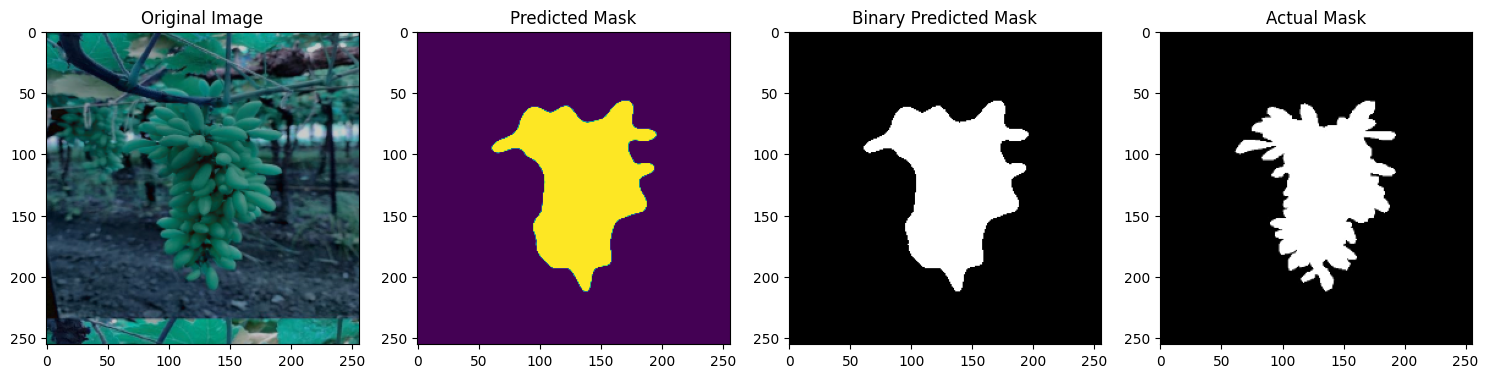

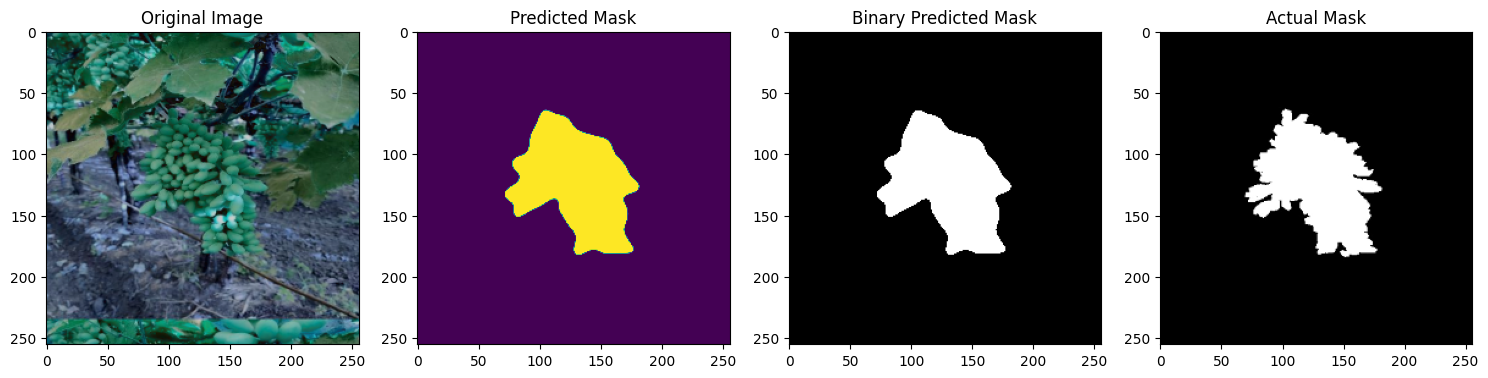

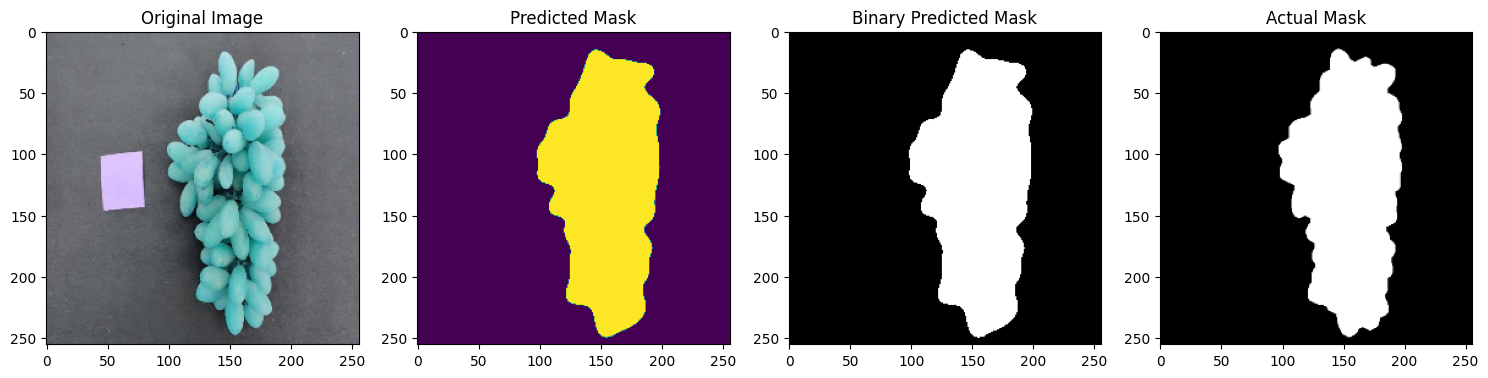

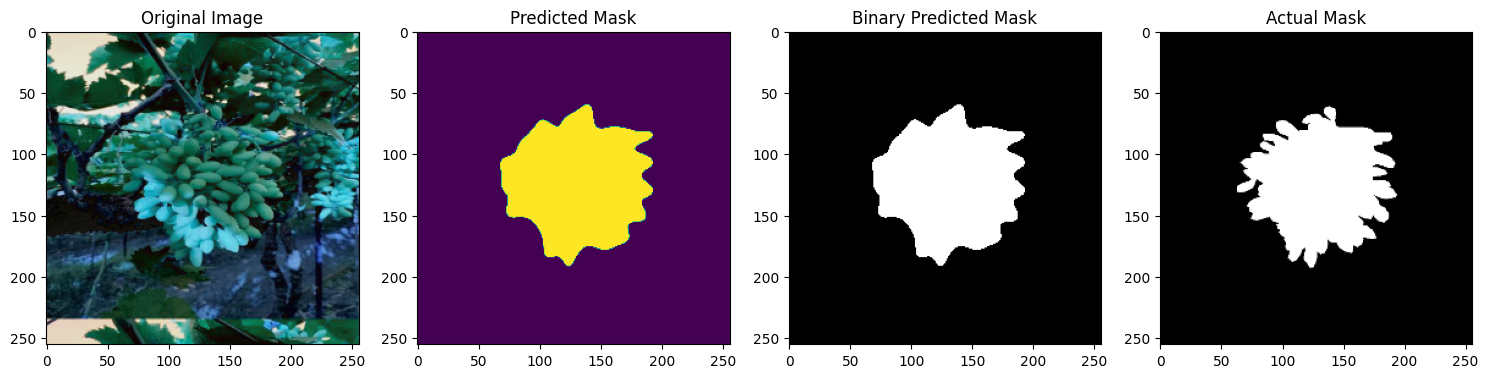

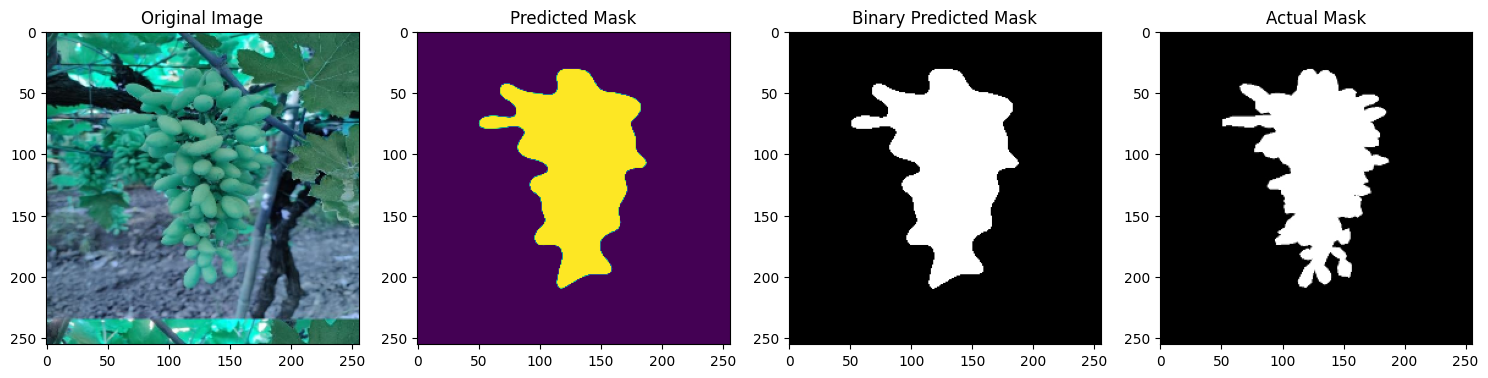

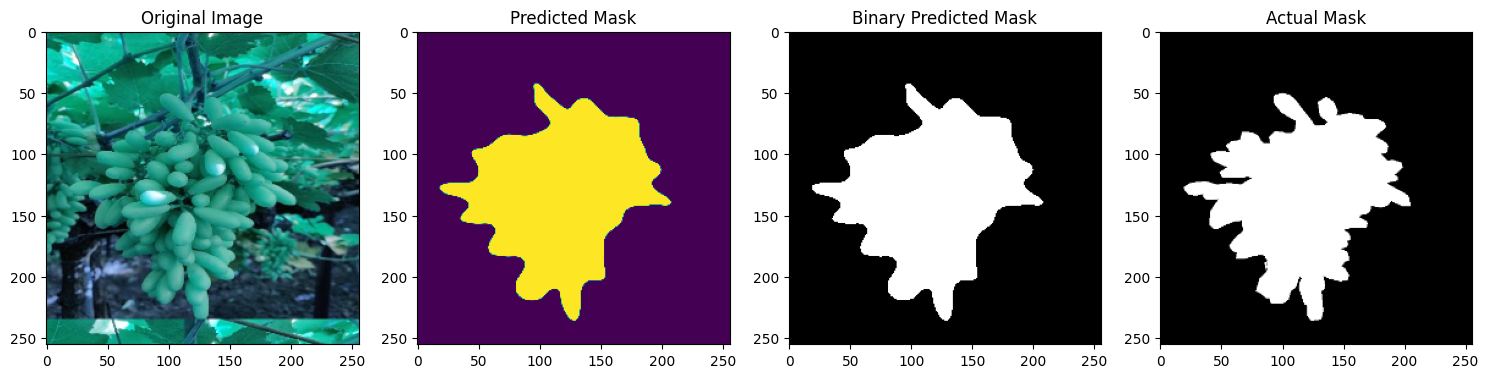

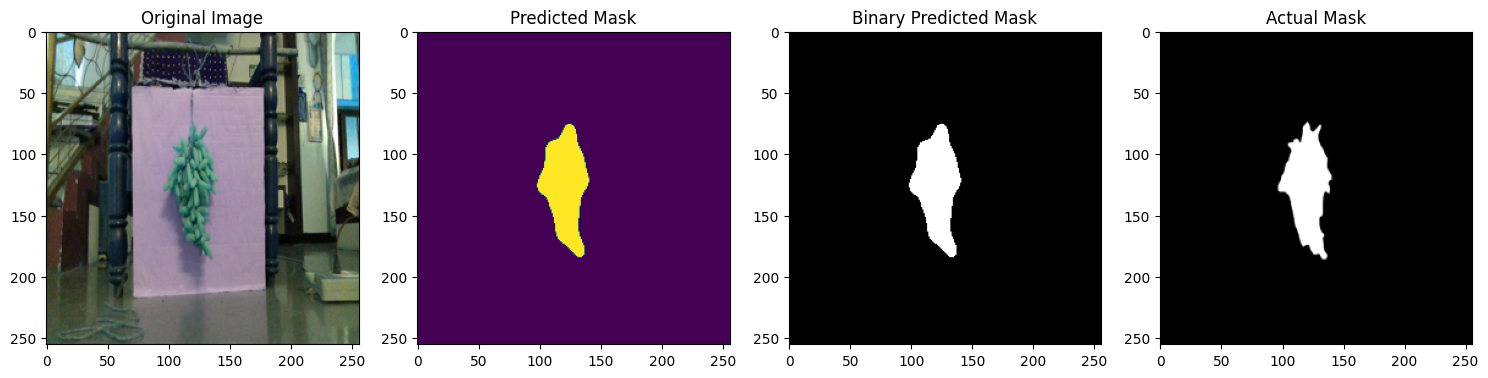

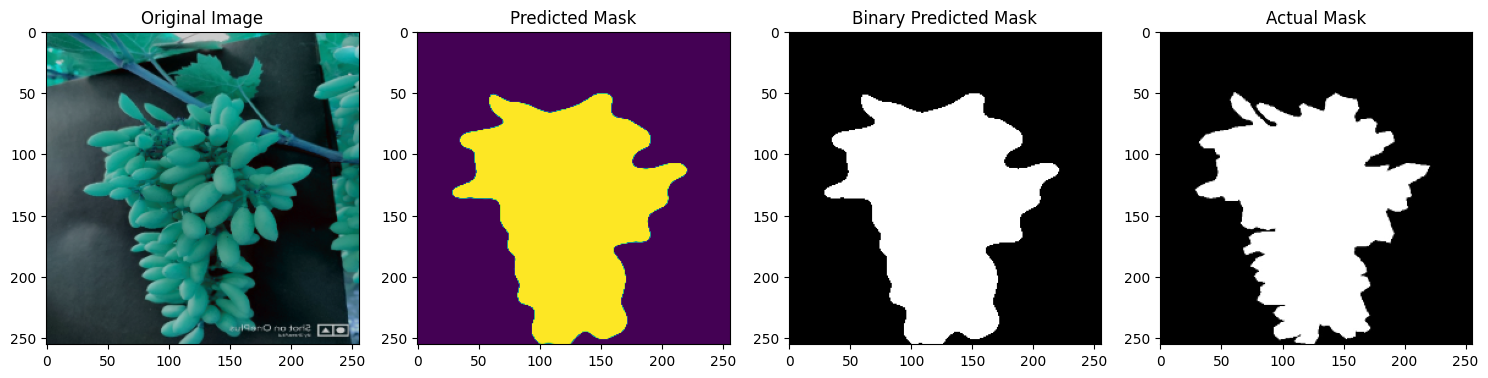

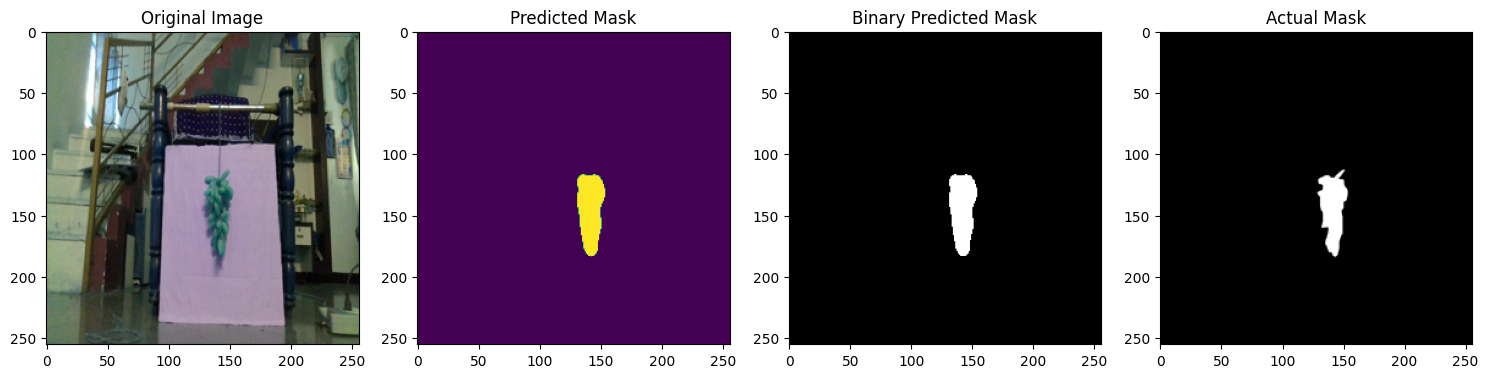

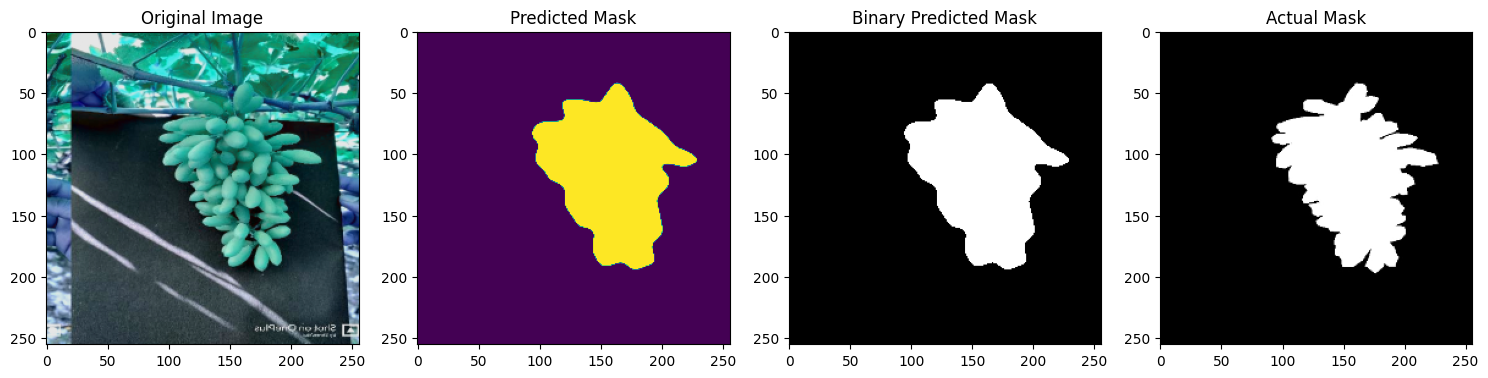

In [ ]:
for i in range(10):
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(images_test1[i])
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(masks_test1[i], cmap='gray')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask1[i], cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
for i in range(10):
    plt.figure(figsize=(8, 4))

    # Predicted Mask
    plt.subplot(1, 1, 1)
    plt.imshow(pred_mask1[i], cmap='gray')
    plt.axis('off')